In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

(86439, 2)

In [4]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


# Preprocessing function

In [5]:
def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', ':', '(', ')', '-', '--', '?', '@', '....', '~',
                     '.', '..', '...', '....................', '<', '>', '=', '»', '|', '’', '`', '+', '$',
                     '&', '#', '+++', '*', '``', '%', '[', ']', '{', '}', '√©']

stop_words = stopwords.words('english') + ['14000kbps', 'november', '1080p', '4k', 'mp4', 'error', '404', '2022']
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [6]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [7]:
data[:1000].apply(lambda row: str(row.text), axis=1)

0                                       My Favorite Slut
1      girlfriends sit on each other's faces with the...
2                     bound beauty kisses her girlfriend
3      MORGAN - Anytime - Nail Painting On The Slave'...
4                      TRANSGENDER COACHING (wmv) PART 1
                             ...                        
995    Captain Next Fucks Hot Wife Laney On Her Husba...
996    Captain Next Fucks Hot Wife Laney On Her Husba...
997    Captain Next Fucks Hot Wife Laney On Her Husba...
998    XY19 - Sexy Chinese Maid Gets Femdom With Vibr...
999     The Strongest Reverse Headscissors Contest HDMP4
Length: 1000, dtype: object

In [8]:
# data[:100].apply(lambda row: bs(row['text']).get_text().replace('\n',' '),axis=1)

In [9]:
data[:100].apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1) #, morph), axis=1)

0                                         favorite slut
1                        girlfriends sit 's faces asses
2                        bound beauty kisses girlfriend
3            morgan anytime nail painting slave 's face
4                       transgender coaching wmv part 1
                            ...                        
95    real mesmerized housewife brooklyn follows orders
96                     kaylia strict hogtie naked floor
97                 real mesmerized submissive housewife
98                        ehesklave muss füsse lutschen
99    uncut buck nekkid fucks creampies polly bundy ...
Length: 100, dtype: object

In [10]:
# Dropping the rows with "<div"
# identify partial string
discard = ["<div ", "<p ", "<span ", "<p>", "<div>", "<h", "<input ", "center>", "<a ", 
           "<td>", "<", ">", r"              ", "Ø", '√ú', 'http://']
  
data = data[~data.text.str.contains('|'.join(discard))]

In [11]:
data['text'] = data.apply(lambda row: bs(row.text, 'lxml').get_text().replace('\r\n', ' ').replace('/', ' ').replace('"', '\"'), axis=1)
# data['text'] = data.apply(lambda row: HTMLParser(row.text).body.text(separator=' ').replace('\r\n',' '),axis=1)

In [12]:
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1)

In [13]:
data

,text,labels,text_preprocessed
0,My Favorite Slut,0,favorite slut
1,girlfriends sit on each other's faces with the...,0,girlfriends sit 's faces asses
2,bound beauty kisses her girlfriend,0,bound beauty kisses girlfriend
3,MORGAN - Anytime - Nail Painting On The Slave'...,0,morgan anytime nail painting slave 's face
4,TRANSGENDER COACHING (wmv) PART 1,0,transgender coaching wmv part 1
...,...,...,...
83594,"ebony,hotwife,wife,swinger,cuckold,bigass",0,ebony hotwife wife swinger cuckold bigass
83595,"ssbhm, bhm, ffa, female fat admire, fat admire...",0,ssbhm bhm ffa female fat admire fat admire fee...
83596,"Feet in heels, sexy shoes, high heels, high he...",0,feet heels sexy shoes high heels high heel fet...
83597,"foot fetish, breeding, kinky, fetish porn, bon...",0,foot fetish breeding kinky fetish porn bondage


In [14]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [15]:
data.head()

,text_preprocessed,labels,text
0,favorite slut,0,My Favorite Slut
1,girlfriends sit 's faces asses,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave 's face,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,TRANSGENDER COACHING (wmv) PART 1


In [16]:
data.to_csv('../datasets/clear_text.csv')

# Tensorflow

In [17]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [18]:
counter = counter_word(data.text_preprocessed)  

In [19]:
data.text_preprocessed

0                                            favorite slut
1                           girlfriends sit 's faces asses
2                           bound beauty kisses girlfriend
3               morgan anytime nail painting slave 's face
4                          transgender coaching wmv part 1
                               ...                        
83594            ebony hotwife wife swinger cuckold bigass
83595    ssbhm bhm ffa female fat admire fat admire fee...
83596    feet heels sexy shoes high heels high heel fet...
83597       foot fetish breeding kinky fetish porn bondage
83598    fetish content ellie boulder ellie boulder por...
Name: text_preprocessed, Length: 61107, dtype: object

In [20]:
num_unique_words = len(counter)

In [21]:
num_unique_words

46057

In [22]:
counter

Counter({'favorite': 43,
         'slut': 1402,
         'girlfriends': 55,
         'sit': 191,
         "'s": 3029,
         'faces': 143,
         'asses': 174,
         'bound': 1181,
         'beauty': 259,
         'kisses': 83,
         'girlfriend': 203,
         'morgan': 128,
         'anytime': 5,
         'nail': 395,
         'painting': 95,
         'slave': 3695,
         'face': 3456,
         'transgender': 93,
         'coaching': 4,
         'wmv': 1367,
         'part': 1128,
         '1': 632,
         '2212terra-kept': 1,
         'tied': 1077,
         'gagged': 1118,
         'garage': 11,
         'cadence': 24,
         'gets': 268,
         'catfished': 3,
         '2': 835,
         '3': 377,
         'mobile': 176,
         'lick': 573,
         'sexy': 3877,
         'mules': 118,
         'clean': 126,
         'shoe': 1692,
         'worship': 6706,
         'domination': 9319,
         'gorgeous': 102,
         'yet': 13,
         'hangry': 1,
         

In [23]:
counter.most_common(150)

[('fetish', 21782),
 ('foot', 16165),
 ('feet', 13306),
 ('domination', 9319),
 ('ass', 9178),
 ('big', 7585),
 ('worship', 6706),
 ('clip', 6689),
 ('store', 6409),
 ('bondage', 6317),
 ('female', 6146),
 ('femdom', 5822),
 ('cum', 5727),
 ('humiliation', 4799),
 ('heels', 4722),
 ('balloon', 4654),
 ('girl', 4359),
 ('blow', 4358),
 ('sex', 4315),
 ('pantyhose', 4096),
 ('sexy', 3877),
 ('milf', 3869),
 ('pussy', 3813),
 ('high', 3798),
 ('pov', 3777),
 ('slave', 3695),
 ('crush', 3672),
 ('tits', 3660),
 ('farting', 3602),
 ('mistress', 3558),
 ('soles', 3506),
 ('cock', 3466),
 ('face', 3456),
 ('amateur', 3428),
 ('tickling', 3350),
 ('stockings', 3335),
 ('girls', 3285),
 ('legs', 3044),
 ("'s", 3029),
 ('masturbation', 3010),
 ('goddess', 2981),
 ('fucking', 2905),
 ('play', 2899),
 ('crushing', 2859),
 ('smoking', 2844),
 ('wrestling', 2738),
 ('anal', 2705),
 ('spanking', 2694),
 ('clips', 2635),
 ('bdsm', 2595),
 ('socks', 2568),
 ('bbw', 2549),
 ('training', 2544),
 ('tease'

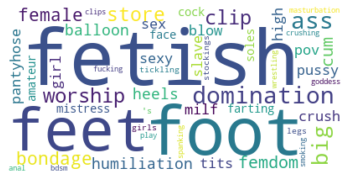

In [24]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [25]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [26]:
train.text_preprocessed.to_numpy()

array(['favorite slut', "girlfriends sit 's faces asses",
       'bound beauty kisses girlfriend', ...,
       'watch heather take behind gets banged loves every minute touching balls licking fingers pleasure watch cum shoots cum face letting drip slowly',
       'already website encourage come join fun stop say hi message board www.sockittothepedal.com',
       'e mail us britfet2006 yahoo.co.uk'], dtype=object)

In [27]:
X_train,  y_train

(array(['favorite slut', "girlfriends sit 's faces asses",
        'bound beauty kisses girlfriend', ...,
        'watch heather take behind gets banged loves every minute touching balls licking fingers pleasure watch cum shoots cum face letting drip slowly',
        'already website encourage come join fun stop say hi message board www.sockittothepedal.com',
        'e mail us britfet2006 yahoo.co.uk'], dtype=object),
 array([0, 0, 0, ..., 0, 0, 0]))

In [28]:
X_train.shape, X_val.shape

((48885,), (12222,))

# Tokenize

In [29]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer2 = Tokenizer(num_words=num_unique_words)
tokenizer2.fit_on_texts(X_train)

In [30]:
import pickle

# saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [31]:
# each word have a unique index
word_index = tokenizer.word_index
word_index

{'fetish': 1,
 'foot': 2,
 'feet': 3,
 'domination': 4,
 'ass': 5,
 'big': 6,
 'worship': 7,
 'bondage': 8,
 'female': 9,
 'cum': 10,
 'femdom': 11,
 'clip': 12,
 'girl': 13,
 'humiliation': 14,
 'heels': 15,
 'store': 16,
 'balloon': 17,
 'blow': 18,
 'sex': 19,
 'pantyhose': 20,
 'high': 21,
 'milf': 22,
 'sexy': 23,
 'pussy': 24,
 'pov': 25,
 'crush': 26,
 'slave': 27,
 'farting': 28,
 'tits': 29,
 'face': 30,
 'soles': 31,
 'cock': 32,
 'mistress': 33,
 'stockings': 34,
 'amateur': 35,
 'tickling': 36,
 'girls': 37,
 'legs': 38,
 'masturbation': 39,
 'fucking': 40,
 'play': 41,
 'crushing': 42,
 'smoking': 43,
 'goddess': 44,
 'wrestling': 45,
 "'s": 46,
 'spanking': 47,
 'anal': 48,
 'training': 49,
 'clips': 50,
 'socks': 51,
 'bdsm': 52,
 'bubble': 53,
 'tease': 54,
 'lesbian': 55,
 'bbw': 56,
 'fuck': 57,
 'toes': 58,
 'videos': 59,
 'black': 60,
 'video': 61,
 'dirty': 62,
 'hot': 63,
 'boots': 64,
 'shoes': 65,
 'women': 66,
 'hd': 67,
 'leather': 68,
 'woman': 69,
 'tramplin

In [32]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [33]:
print(X_train[1])
print(X_train_sequences[1])

girlfriends sit 's faces asses
[1844, 696, 46, 882, 766]


In [34]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 20

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape


((48885, 20), (12222, 20))

In [35]:
X_train_padded[10]

array([ 970, 8800,  272,   23,  986,  948,   82,    7,    4,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [36]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

morgan anytime lick sexy mules clean shoe worship domination
[970, 8800, 272, 23, 986, 948, 82, 7, 4]
[ 970 8800  272   23  986  948   82    7    4    0    0    0    0    0
    0    0    0    0    0    0]


In [37]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [38]:
reverse_word_index

{1: 'fetish',
 2: 'foot',
 3: 'feet',
 4: 'domination',
 5: 'ass',
 6: 'big',
 7: 'worship',
 8: 'bondage',
 9: 'female',
 10: 'cum',
 11: 'femdom',
 12: 'clip',
 13: 'girl',
 14: 'humiliation',
 15: 'heels',
 16: 'store',
 17: 'balloon',
 18: 'blow',
 19: 'sex',
 20: 'pantyhose',
 21: 'high',
 22: 'milf',
 23: 'sexy',
 24: 'pussy',
 25: 'pov',
 26: 'crush',
 27: 'slave',
 28: 'farting',
 29: 'tits',
 30: 'face',
 31: 'soles',
 32: 'cock',
 33: 'mistress',
 34: 'stockings',
 35: 'amateur',
 36: 'tickling',
 37: 'girls',
 38: 'legs',
 39: 'masturbation',
 40: 'fucking',
 41: 'play',
 42: 'crushing',
 43: 'smoking',
 44: 'goddess',
 45: 'wrestling',
 46: "'s",
 47: 'spanking',
 48: 'anal',
 49: 'training',
 50: 'clips',
 51: 'socks',
 52: 'bdsm',
 53: 'bubble',
 54: 'tease',
 55: 'lesbian',
 56: 'bbw',
 57: 'fuck',
 58: 'toes',
 59: 'videos',
 60: 'black',
 61: 'video',
 62: 'dirty',
 63: 'hot',
 64: 'boots',
 65: 'shoes',
 66: 'women',
 67: 'hd',
 68: 'leather',
 69: 'woman',
 70: 'tram

In [39]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(X_train_sequences[10])

print(X_train_sequences[10])
print(decoded_text)

[970, 8800, 272, 23, 986, 948, 82, 7, 4]
morgan anytime lick sexy mules clean shoe worship domination


In [40]:
# Create LSTM model
from tensorflow.keras import layers

# Word embeddings give us a way to use an efficient, dense representation in which similar words have
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify)

# tf.debugging.set_log_device_placement(True)

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input as integer matrix of size (batcg, input_length)
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

model.add(layers.LSTM(64, dropout=.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            1473824   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,498,721
Trainable params: 1,498,721
Non-trainable params: 0
_________________________________________________________________


In [41]:
from pathlib import Path
path = Path('../models/bad_words.model')
path.mkdir(exist_ok=True) 
cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, 
                                                save_best_only=True, mode='min')

In [42]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [43]:
model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_val_padded, y_val), verbose=1, 
          callbacks=[checkpoint])

Epoch 1/15
1528/1528 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9765
Epoch 1: val_loss improved from inf to 0.01835, saving model to ../models/bad_words.model/01_checkpoint_0.02.hdf5
1528/1528 [==============================] - 23s 14ms/step - loss: 0.0814 - accuracy: 0.9765 - val_loss: 0.0184 - val_accuracy: 0.9966
Epoch 2/15
1527/1528 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9892
Epoch 2: val_loss did not improve from 0.01835
1528/1528 [==============================] - 20s 13ms/step - loss: 0.0331 - accuracy: 0.9892 - val_loss: 0.0243 - val_accuracy: 0.9967
Epoch 3/15
1525/1528 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9936
Epoch 3: val_loss did not improve from 0.01835
1528/1528 [==============================] - 20s 13ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0216 - val_accuracy: 0.9962
Epoch 4/15
1526/1528 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.

In [44]:
# model.get_weights()

In [45]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.081365,0.976496,0.018352,0.996564
1,0.033128,0.989220,0.024299,0.996727
2,0.019578,0.993577,0.021599,0.996236
3,0.013019,0.995316,0.022225,0.995991
4,0.009310,0.996768,0.027313,0.994682
5,0.007522,0.997177,0.023299,0.995745
6,0.005545,0.998241,0.027292,0.996727
7,0.005107,0.998179,0.026166,0.995091
8,0.004448,0.998425,0.022887,0.995336
9,0.003790,0.998936,0.023163,0.996400


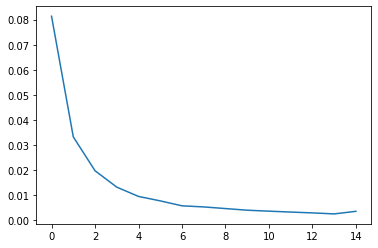

In [46]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss);

In [47]:
model.load_weights('../models/bad_words.model/04_checkpoint_0.02.hdf5') # loading weights - model had created erlier
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

382/382 [==============================] - 2s 4ms/step - loss: 0.0184 - accuracy: 0.9962
Accuracy of restored model 99.62%


In [48]:
model = tf.keras.models.load_model('../models/bad_words.model/04_checkpoint_0.02.hdf5')
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

382/382 [==============================] - 2s 4ms/step - loss: 0.0184 - accuracy: 0.9962
Accuracy of restored model 99.62%


In [49]:
!ls '../models/bad_words.model'

01_checkpoint_0.02.hdf5 01_checkpoint_0.17.hdf5 05_checkpoint_0.04.hdf5
01_checkpoint_0.04.hdf5 01_checkpoint_0.18.hdf5 06_checkpoint_0.03.hdf5
01_checkpoint_0.14.hdf5 02_checkpoint_0.15.hdf5 07_checkpoint_0.02.hdf5
01_checkpoint_0.15.hdf5 03_checkpoint_0.04.hdf5 08_checkpoint_0.02.hdf5
01_checkpoint_0.16.hdf5 04_checkpoint_0.02.hdf5


In [50]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1528/1528 [==============================] - 5s 3ms/step


In [153]:
X_train_padded[0]

array([2920,  115,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [51]:
print(X_train[2000:2010])
print(y_train[2000:2010])
print(predictions[2000:2010])

['make erection go away wmv hd' 'hentai girl3'
 'elegant close-up marlboro reds vinyl leather nose exhales long drag high heels'
 'made cum twice sexy toes day' 'hardcore anal exploration endoscope'
 'amazon daria big sexy feet footstool face foot worship ignore'
 'psychologist cures' 'hentai girl4' 'romantic fucking husband'
 'conflicted mov']
[0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [52]:
train['predictions'] = predictions
train = train[['text_preprocessed', 'labels', 'predictions', 'text']] # columns reorder

In [53]:
train.head()

,text_preprocessed,labels,predictions,text
0,favorite slut,0,0,My Favorite Slut
1,girlfriends sit 's faces asses,0,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave 's face,0,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,0,TRANSGENDER COACHING (wmv) PART 1


In [54]:
train.to_csv('../datasets/wo_html.csv')

In [55]:
model.save('../models/modelSequential_wo_HTML.h5')

In [56]:
#model_new = keras.models.load_model('../models/modelSequential.h5')
model_new = keras.models.load_model('../models/bad_words.model/04_checkpoint_0.02.hdf5')

In [57]:
predictions = model_new.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1528/1528 [==============================] - 5s 3ms/step


# Check sentence

In [127]:
raw_text = "Welcome to Jandro The Tickler. What \
          you're seeing here is completely real! So here's the premise: Husbands, \
          boyfriends, friends, etc, hire me, \"The Tickler\", to show \
          up at a specified location at a specific time with one mission: Find \
          the girl, tie her up, surprise her, and tickle the hell out of her! \
          Sometimes the girls are in the know, and sometimes they're not:) The \
          bonds are real, the reactions are certainly real, and the tickle tools \
          are 100% real. The end result is usually a surprised, shocked, tortured, \
          turned on, worn out girl, with hardly the strength to wave at the camera \
          before I exit:) I basically wanted to combine Tickle Torture with Foot, \
          Sleepy, Voyeur, Light Bondage, and even Forced O. The premise allows \
          all of these to take place per vid."
test_text_preprocessed = bs(raw_text, 'lxml').get_text().replace('\r\n',' ')
test_text_preprocessed = preprocess(test_text_preprocessed, punctuation_marks, stop_words)
test_text_np = np.array([test_text_preprocessed])
test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [128]:
print(test_text_preprocessed)
print(test_sequences[0])

welcome jandro tickler . 're seeing completely real premise husbands boyfriends friends etc hire tickler '' show specified location specific time one mission find girl tie surprise tickle hell sometimes girls know sometimes 're bonds real reactions certainly real tickle tools 100 real . end result usually surprised shocked tortured turned worn girl hardly strength wave camera exit basically wanted combine tickle torture foot sleepy voyeur light bondage even forced o. premise allows take place per vid .
[1317, 2000, 2109, 9445, 7238, 200, 3864, 5743, 685, 2348, 7989, 2000, 789, 821, 15686, 10258, 354, 437, 28286, 2296, 13, 832, 2564, 80, 3019, 5321, 37, 1798, 5321, 2109, 5074, 200, 28269, 200, 80, 5620, 1471, 200, 2788, 28011, 14355, 5820, 2147, 2276, 1609, 13, 16797, 3970, 453, 4680, 80, 155, 2, 1382, 174, 1372, 8, 3368, 121, 2698, 27738, 1246, 1823, 1166, 4575]


In [129]:
# for word in test_text_preprocessed:

test_sequences_padded = pad_sequences(test_sequences, padding="post", truncating="post")

In [130]:
print(test_text_preprocessed)
print(*test_sequences_padded)

welcome jandro tickler . 're seeing completely real premise husbands boyfriends friends etc hire tickler '' show specified location specific time one mission find girl tie surprise tickle hell sometimes girls know sometimes 're bonds real reactions certainly real tickle tools 100 real . end result usually surprised shocked tortured turned worn girl hardly strength wave camera exit basically wanted combine tickle torture foot sleepy voyeur light bondage even forced o. premise allows take place per vid .
[ 1317  2000  2109  9445  7238   200  3864  5743   685  2348  7989  2000
   789   821 15686 10258   354   437 28286  2296    13   832  2564    80
  3019  5321    37  1798  5321  2109  5074   200 28269   200    80  5620
  1471   200  2788 28011 14355  5820  2147  2276  1609    13 16797  3970
   453  4680    80   155     2  1382   174  1372     8  3368   121  2698
 27738  1246  1823  1166  4575]


In [113]:
%%time
predictions = model_new.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1/1 [==============================] - 0s 320ms/step
CPU times: user 265 ms, sys: 70.5 ms, total: 336 ms
Wall time: 384 ms


In [114]:
predictions

[1]

In [131]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 20

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', ':', '(', ')', '-', '--', '?', '@', '....', '~', '¬ß'
                     '.', '..', '...', '....................', '<', '>', '=', '»', '|', '’', '`', '+', '$',
                     '&', '#', '+++', '*', '``', '%', '[', ']', '{', '}', '√©', '√™', '¬†', '√¢']


stop_words = stopwords.words('english') + ['14000kbps', 'https', "'s", "'m", 'http', 'mp4', 'error', '404',
                                          'Error 404', '404error']

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
model = keras.models.load_model('../models/modelSequential_wo_HTML.h5')

raw_text = 'nigger'


def predict(sequences):
    sequences_padded = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
    predictions = model.predict(sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]
    return predictions

# Data loading and preparation
data = pd.read_json('../datasets/neil_ProducerClipSite_rand.json')
mapping = {False: 0, True: 1}
# data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
# data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['SiteID', 'Title', 'Description', 'Keywords', 'Bottom'], axis=1, inplace=True)
data.head()



[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Top
0,
1,
2,
3,
4,


In [125]:
data.Top

0                                                        
1                                                        
2                                                        
3                                                        
4                                                        
                              ...                        
9995                                                     
9996    <center><div class='top_html' align='center'><...
9997                                                     
9998                                                     
9999                                                     
Name: Top, Length: 10000, dtype: object

In [142]:
%%time
data['text'] = data.apply(lambda row: bs(row.Top, 'lxml').get_text().replace('\r\n',' ').replace('.', ''), axis=1)
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1)

X_val = data.text_preprocessed.to_numpy()
X_val_sequences = tokenizer.texts_to_sequences(X_val)
#X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, padding="post", truncating="post")


predictions = model.predict(X_val_padded)
predictions = [1 if p > .5 else 0 for p in predictions]


ValueError: in user code:

    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 20), found shape=(None, 322)


In [166]:

X_val_padded[100:102]


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [120]:
data['predictions'] = predictions

In [67]:
data.head()

,Top,text,text_preprocessed,predictions
0,,,,0
1,,,,0
2,,,,0
3,,,,0
4,,,,0


In [68]:
data = data[['Top', 'predictions']]

In [69]:
data.to_csv('../datasets/last_one.csv')

In [70]:
data.to_json('../datasets/last_one.json')